# Imports

In [1]:
%%capture
!pip install seaborn
!pip install ucimlrepo
!pip install yellowbrick
!pip install -U scikit-fuzzy

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from skfuzzy.cluster import cmeans

# Loading dataset

Link to Wine Quality dataset: https://archive.ics.uci.edu/dataset/186/wine+quality

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets

In [4]:
X.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


## Features normalization

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(X)

# Kmeans

### Calculating elbow score for different k's

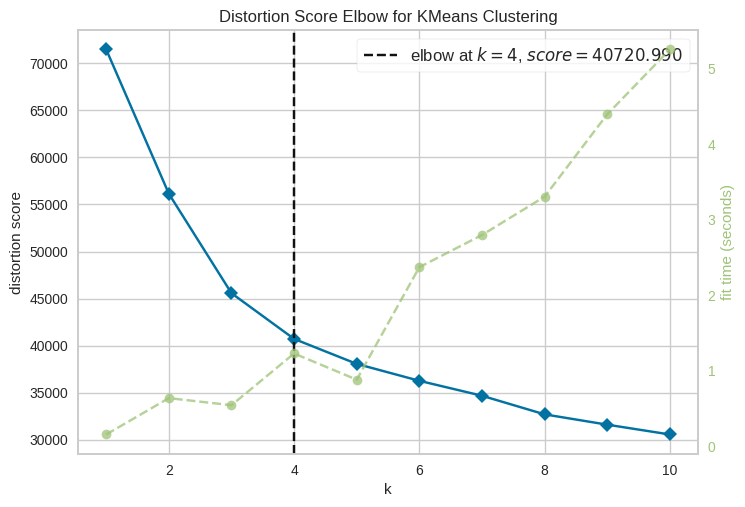

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(1, 11))

visualizer.fit(X)
visualizer.poof()

Apparently, the higher the k, the lowest the score, but choosing a value too high would likely lead to overfitting, so it would be best to settle at k=3, since the gains after this value are not so significant.

### Calculating silhouette coefficient for different k's

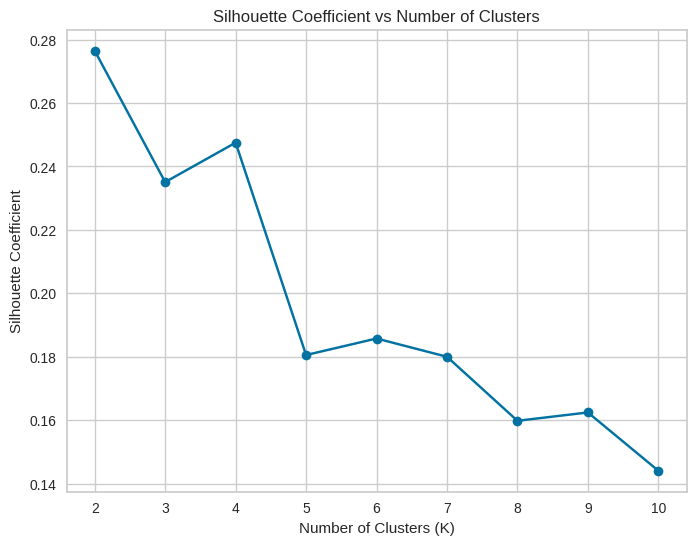

In [7]:
k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(X)
    clusters = kmeans.fit_predict(X)

    silhouette = metrics.silhouette_score(X, clusters)
    silhouette_scores.append(silhouette)

# Plot line plot of silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Coefficient vs Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Coefficient')
plt.xticks(k_values)
plt.grid(True)
plt.show()

The silhouette coefficient indicates that actually k=2 would be optimal.

### Clusters visualization

In [8]:
k = 2

kmeans = KMeans(n_clusters=k, n_init=10)
kmeans.fit(X)
clusters = kmeans.fit_predict(X)

centroids = kmeans.cluster_centers_
labels = np.unique(clusters)

To visualize the clusters in a 2-D chart, we need first to decompose our features to only 2, which will unfortunately result in a loss of information

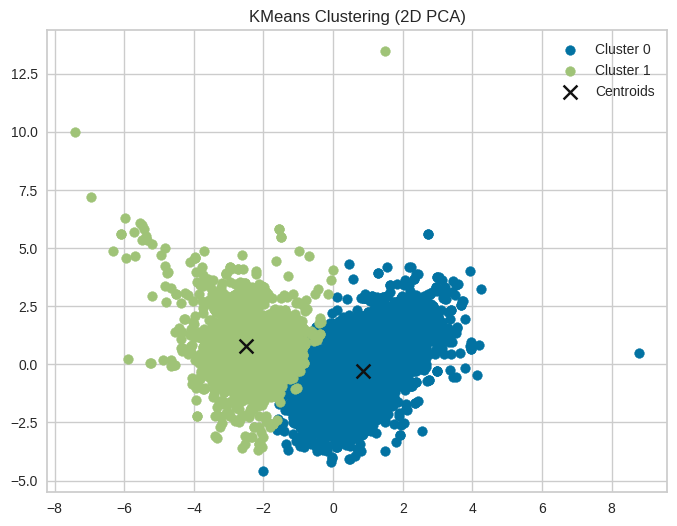

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Get centroids in 2D space
centroids = pca.transform(kmeans.cluster_centers_)

# Plot clusters
plt.figure(figsize=(8, 6))

for cluster_label in np.unique(clusters):
    plt.scatter(X_pca[clusters == cluster_label, 0],
                X_pca[clusters == cluster_label, 1],
                label=f'Cluster {cluster_label}')

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='k', s=100, label='Centroids')

plt.title('KMeans Clustering (2D PCA)')
plt.legend()
plt.grid(True)
plt.show()

# DBSCAN

### Finding best parameters

We will use a 2-distance plot and try to discover the optimal value for eps.

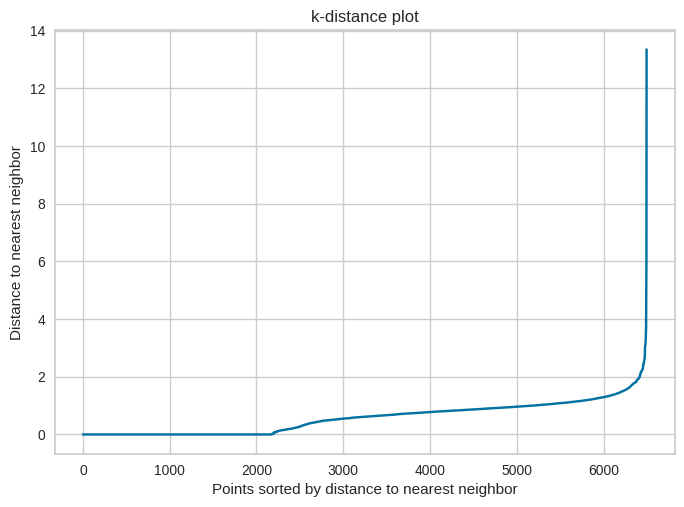

In [10]:
# Fit a nearest neighbors model
nn = NearestNeighbors(n_neighbors=2).fit(X)
distances, indices = nn.kneighbors(X)

# Sort the distances of each point by the k-th nearest neighbor
distances = np.sort(distances, axis=0)
distances = distances[0:,1]

# Plot the k-distance plot
plt.plot(distances)
plt.xlabel('Points sorted by distance to nearest neighbor')
plt.ylabel('Distance to nearest neighbor')
plt.title('k-distance plot')
plt.show()

In [11]:
eps_value = 1.85

Now let's simulate multiple values for min_samples parameters with the eps_value we found, and pick the best result.

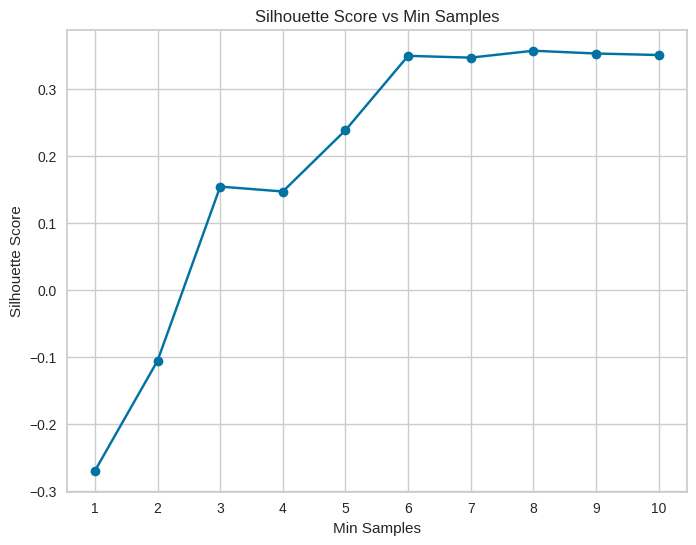

In [12]:
min_samples_values = range(1, 11)
silhouette_scores = []

for min_samples in min_samples_values:
    dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
    clusters = dbscan.fit_predict(X)
    silhouette = metrics.silhouette_score(X, clusters)
    silhouette_scores.append(silhouette)

# Plot line plot of silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(min_samples_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Min Samples')
plt.xlabel('Min Samples')
plt.ylabel('Silhouette Score')
plt.xticks(min_samples_values)
plt.grid(True)
plt.show()

In [13]:
best_min_samples = 6

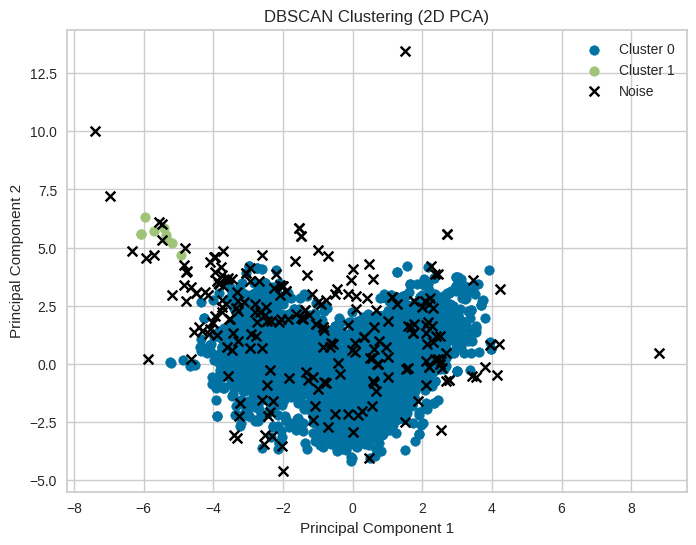

In [14]:
# Apply DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=best_min_samples)
clusters = dbscan.fit_predict(X)

# Get unique labels (clusters), ignoring noise points (-1)
unique_labels = np.unique(clusters[clusters != -1])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Get unique labels (clusters), ignoring noise points (-1)
unique_labels = np.unique(clusters[clusters != -1])

# Plot clusters
plt.figure(figsize=(8, 6))
for label in unique_labels:
    cluster = X_pca[clusters == label]
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {label}')

# Plot noise points (cluster == -1)
noise_points = X_pca[clusters == -1]
plt.scatter(noise_points[:, 0], noise_points[:, 1], color='black', marker='x', label='Noise')

plt.title('DBSCAN Clustering (2D PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()



```
# Isto está formatado como código
```

# Fuzzy Cmeans

We will iterate through multiple number of clusters and m values combination and evaluate their Fuzzy Partition Coefficient, to later pick the best one.

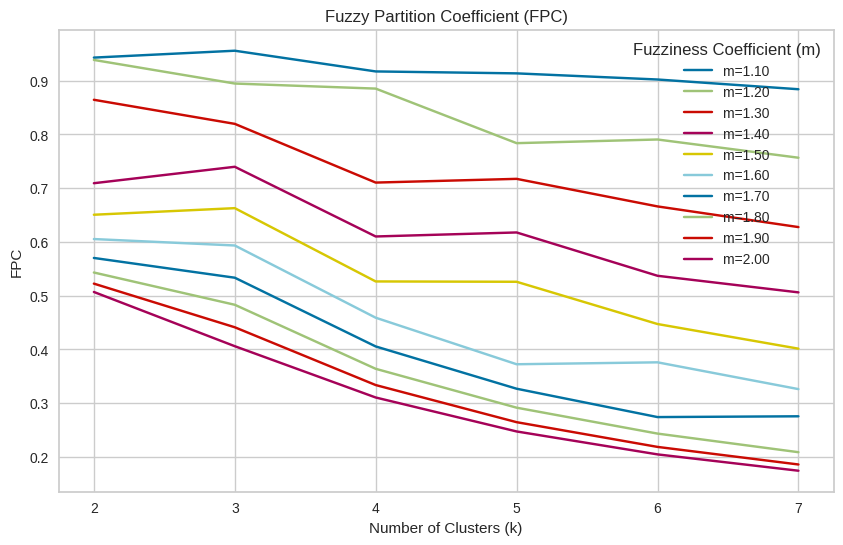

In [16]:
k_range = range(2, 8)
m_range = np.linspace(1.1, 2.0, 10)  # Adjust the range as needed

# Calculate FPC for each combination of k and m
fpcs = np.zeros((len(k_range), len(m_range)))

for i, k in enumerate(k_range):
    for j, m in enumerate(m_range):
        _, u, _, _, _, _, _ = cmeans(X.T, k, m, error=0.005, maxiter=1000)
        fpcs[i, j] = np.sum(u ** 2) / len(X)

# Plot FPC values against the number of clusters and fuzziness coefficient
plt.figure(figsize=(10, 6))
for j, m in enumerate(m_range):
    plt.plot(k_range, fpcs[:, j], label=f'm={m:.2f}')

plt.title('Fuzzy Partition Coefficient (FPC)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('FPC')
plt.legend(title='Fuzziness Coefficient (m)')
plt.grid(True)
plt.show()

In [17]:
n_clusters_value = 2
m_value = 1.1

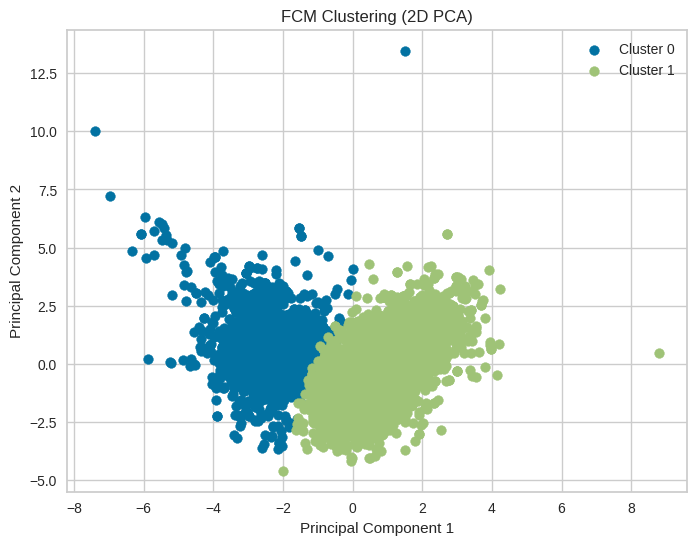

In [18]:
fuzzy_centroids, u, _, _, _, _, _ = cmeans(X.T, n_clusters_value, m_value, error=0.005, maxiter=1000)

# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot clusters
plt.figure(figsize=(8, 6))
for i in range(n_clusters_value):
    plt.scatter(X_pca[u.argmax(axis=0) == i, 0], X_pca[u.argmax(axis=0) == i, 1], label=f'Cluster {i}')

plt.title('FCM Clustering (2D PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

# Implementando KMeans


In [51]:
from sklearn.preprocessing import StandardScaler

def dist(p, data):
  return np.sqrt(np.sum((p - data)**2, axis=1)) # Distance from a point to the centroids

def kmeans_fit(X, k, iters=100):
  """
  X = Training Data
  k = Number of Clusters
  """

  # Initialize centroids randomly
  centroids = X[np.random.choice(X.shape[0], k, replace=False)]

  # Refine centroids in at most K iterations or until centroids don't change
  iteration = 0
  prev_centroids = None
  while np.not_equal(centroids, prev_centroids).any() and iteration < iters: # Check if not exceeding k or centroids haven't changed
    sorted_points = [[] for cluster in range(k)] # Initialize points belonging to each cluster

    for x in X:
      dists = dist(x, centroids) # Distances to all clusters
      centroid_idx = np.argmin(dists) # Use the nearest centroid
      sorted_points[centroid_idx].append(x) # Add point x to the nearest cluster

      prev_centroids = centroids
      centroids = [np.mean(cluster, axis=0) for cluster in sorted_points] # For each cluster, update centroids by taking the mean of its points
      for i, centroid in enumerate(centroids):
          if np.isnan(centroid).any():  # Check if clusters have at least one point
              centroids[i] = prev_centroids[i]
      iteration += 1

  return centroids # Return centroids of the points


In [53]:
def evaluate(X, centroids):
        p_centroids = []
        centroid_idxs = []
        for x in X:
            dists = dist(x, centroids)
            centroid_idx = np.argmin(dists)
            p_centroids.append(centroids[centroid_idx]) # Assigns each point to its centroid
            centroid_idxs.append(centroid_idx)

        return p_centroids, centroid_idxs

In [54]:
X = StandardScaler().fit_transform(X)
centroids = kmeans_fit(X, k=2)
cluster_centers, classification = evaluate(X, centroids)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


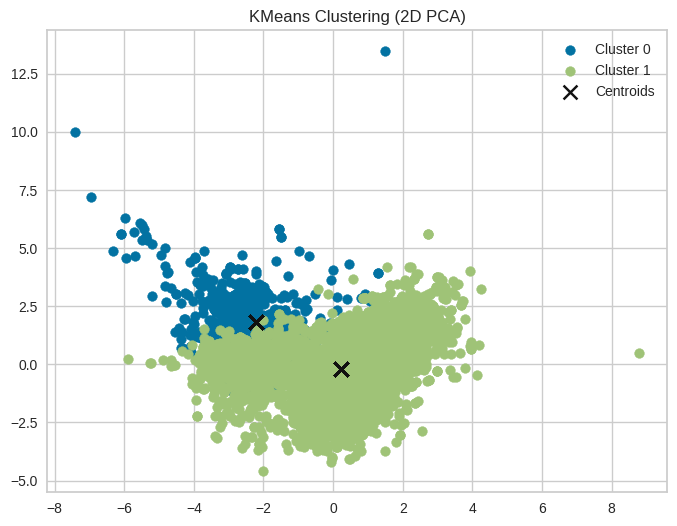

In [56]:
# Get centroids in 2D space
centroids = pca.transform(cluster_centers)

# Plot clusters
plt.figure(figsize=(8, 6))

for cluster_label in np.unique(classification):
    plt.scatter(X_pca[classification == cluster_label, 0],
                X_pca[classification == cluster_label, 1],
                label=f'Cluster {cluster_label}')

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='k', s=100, label='Centroids')

plt.title('KMeans Clustering (2D PCA)')
plt.legend()
plt.grid(True)
plt.show()